In [ ]:
!pip install padelpy
!pip install RDKit

In [2]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# PaDEL
from padelpy import from_smiles

# RDKit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Sklearn
from sklearn import metrics, neighbors, linear_model
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

# Project 2: Predicting drug toxicity using molecular structure

Drug development is extremely resource-intensive; taking all (pre) clinical steps into account, it may take upwards of 10-15 years before a compound is approved for clinical use, costing pharmaceutical companies billions in the process (Paul, Mytelka, Dunwiddie *et al*, 2010). Adding the fact that the vast majority of candidate drugs never reaches the market, the need for early molecular toxicity screening becomes abundantly clear.

Though molecular toxicty may act through a number of differen pathways/receptors, *in silico* screening often focuses on the human Ether-à-go-go-Related Gene, which plays a critical role in cardiovascular activity (Garrido *et al.*, 2020). Inhibition may lead to fatal types of cardiac arrhythmias, necessitating the detection of such harmful compounds at an early stage to avoid wasting valuable time and resources.

We attempted to design and implement an effective pipeline to screen the hERG toxicity of a compound based on its molecular structure. In this report we aim to discuss our findings, as a means of supporting future research.




## Data

Training data consisted of ~214 000 molecules in SMILES format, and their associated hERG toxicity as a binary outcome. No other features were provided.

In [3]:
# Load data from GitHub
smiles_data = pd.read_csv("https://raw.githubusercontent.com/eevenepo/hERG_toxicity_assesment/main/train_data.csv")
del smiles_data['Unnamed: 0']

# Inspect data
print(f'Database size: {len(smiles_data.index)} molecules')

smiles_data.head()

Database size: 214825 molecules


,Drug,Y
0,COc1cccc(CNC(=O)c2ccc(C3SCCS3)cc2)c1,0
1,COc1cccc(/C=N/NC(=O)CSc2cccc3cccnc23)c1,0
2,O=C(CSc1cccc2cccnc12)N/N=C/c1ccc(F)cc1,0
3,CCOc1cc(/C=N/NC(=O)CSc2cccc3cccnc23)ccc1O,0
4,O=C(CSc1cccc2cccnc12)N/N=C/c1cccc(O)c1,0


## Feature extraction

High-performance predictive models rely on quality features to optimize their predictive power. Thus, determining which molecular features are the most relevant for hERG toxicity is an integral part of designing an efficient drug screening tool.

An important tradeoff must be made between the number of features and the computational cost required for to extract them. In addition, algorithm training times can become prohibitively long when working with high dimensional data. Lack of access to a more performant computer required some degree of pragmatism.

We implemented two approaches to feature extraction.

  1. **PaDEL-descriptor**:
    
*   Industry standard 
*   Automatic feature selection
*   Large featureset (1875 descriptors)
*   Computationally expensive


2. **RDKit**:
* Pragmatic approach
* Manual feature selection
* Small featureset (~50 --> 10 descriptors)
* Fast

We briefly elaborate on these methods.

### PaDEL-descriptor


PaDEL-descriptor is a program used to extract molecular descriptors from various chemical formats, including SMILES (Yap, 2011). It has been cited over 1,400 times in various cheminformatics papers, and is available in Python through [padelpy](https://github.com/ecrl/padelpy). In our project, PaDEL's strength proved to also be its biggest weakness; due to the high amount of descriptors (1875), significant runtime is required to perform feature extraction on large molecular datasets.

In [4]:
# Take a small subset 
example_drugs = list(smiles_data['Drug'][:5])

# Calculate PaDEL descriptors
times, total_time = [], 0
print('PaDEL runtime (seconds):')
for i, drug in enumerate(example_drugs):

  # Start
  start = time.time()

  # Calculate features
  features = from_smiles(drug)

  # Stop
  stop = time.time()

  # Time
  t = stop - start
  times.append(t)
  total_time += t

  # Output
  print(f'{i+1} molecules: {total_time:.3}')

# Estimate runtime for complete dataset
total_time = datetime.timedelta(seconds = statistics.mean(times) * len(smiles_data))
print(f'Total estimated runtime: {total_time}')

PaDEL runtime (seconds):
1 molecules: 9.04
2 molecules: 21.1
3 molecules: 33.1
4 molecules: 48.1
5 molecules: 63.2
Total estimated runtime: 31 days, 10:27:53.128376


Though such methods undoubtedly provide the most information, we deemed it to be unfeasible, opting instead for a more pragmatic approach. 

### RDkit

Models trained on smaller feature sets may still perform at acceptable levels, given that the selected features exhibit sufficient correlation with the variable we wish to predict (hERG toxicity).

We generated a number of features using [RDKit](https://www.rdkit.org/docs/index.html), an open source cheminformatics library. Functions were selected based on SMILES compatibility and output format.



In [5]:
#Load SMILES molecules into RDKit objects 
smiles_data['Drug_rdkit'] = [Chem.MolFromSmiles(drug) for drug in smiles_data['Drug']]

# Feature list
descriptors = ['CalcChi0n', 'CalcChi0v', 'CalcChi1n', 'CalcChi1v', 'CalcChi2n', 'CalcChi2v', 'CalcChi3n', 'CalcChi3v', 'CalcChi4n', 'CalcChi4v', 'CalcExactMolWt', 'CalcFractionCSP3', 'CalcHallKierAlpha', 'CalcKappa1', 'CalcKappa2', 'CalcKappa3', 'CalcLabuteASA', 'CalcNumAliphaticCarbocycles', 'CalcNumAliphaticHeterocycles', 'CalcNumAliphaticRings', 'CalcNumAmideBonds', 'CalcNumAromaticCarbocycles', 'CalcNumAromaticHeterocycles', 'CalcNumAromaticRings', 'CalcNumAtomStereoCenters', 'CalcNumAtoms', 'CalcNumBridgeheadAtoms', 'CalcNumHBA', 'CalcNumHBD', 'CalcNumHeavyAtoms', 'CalcNumHeteroatoms', 'CalcNumHeterocycles', 'CalcNumLipinskiHBA', 'CalcNumLipinskiHBD', 'CalcNumRings', 'CalcNumRotatableBonds', 'CalcNumSaturatedCarbocycles', 'CalcNumSaturatedHeterocycles', 'CalcNumSaturatedRings', 'CalcNumSpiroAtoms', 'CalcNumUnspecifiedAtomStereoCenters', 'CalcPhi', 'CalcTPSA', '_CalcMolWt']

# Initialize new df to store features
features_df = pd.DataFrame()

# Calculate
for d in descriptors:
  feature = getattr(rdMolDescriptors, d)
  features_df[d] = [feature(x) for x in smiles_data['Drug_rdkit']]

# Check data
features_df.head()


,CalcChi0n,CalcChi0v,CalcChi1n,CalcChi1v,CalcChi2n,CalcChi2v,CalcChi3n,CalcChi3v,CalcChi4n,CalcChi4v,...,CalcNumRings,CalcNumRotatableBonds,CalcNumSaturatedCarbocycles,CalcNumSaturatedHeterocycles,CalcNumSaturatedRings,CalcNumSpiroAtoms,CalcNumUnspecifiedAtomStereoCenters,CalcPhi,CalcTPSA,_CalcMolWt
0,12.950466,14.583459,7.503768,9.601277,5.229724,7.954092,3.654042,6.758439,2.409318,5.268691,...,3,5,0,1,1,0,0,5.514806,38.33,345.489
1,13.677132,14.493628,7.685862,8.671460,5.189738,6.206915,3.451129,4.498091,2.268894,3.102107,...,3,6,0,0,0,0,0,5.637742,63.58,351.431
2,12.646848,13.463345,7.262472,8.248070,4.964675,5.981852,3.227340,4.274302,2.095918,2.929131,...,3,5,0,0,0,0,0,5.176454,54.35,339.395
3,14.754102,15.570598,8.413669,9.399267,5.573299,6.590475,3.641040,4.688002,2.429204,3.262417,...,3,7,0,0,0,0,0,6.272319,83.81,381.457
4,12.716097,13.532594,7.297096,8.282695,5.008110,6.025287,3.227545,4.274507,2.152171,2.985383,...,3,5,0,0,0,0,0,5.076824,74.58,337.404


Calculated features were ranked by correlation to hERG toxicity, and further selected by removing features exhibiting excessive multicollinearity.

In [6]:
# Calculate correlations with Y
correlations_df = pd.DataFrame(columns = ['Feature', 'Correlation to Y'])
for i in features_df:
    corr = smiles_data['Y'].corr(features_df[i])
    correlations_df.loc[len(correlations_df)] = i, abs(corr)

# Sort descending
correlations_df.sort_values(by = 'Correlation to Y', ascending = False).head()

,Feature,Correlation to Y
2,CalcChi1n,0.151342
25,CalcNumAtoms,0.150411
6,CalcChi3n,0.148493
4,CalcChi2n,0.142725
14,CalcKappa2,0.138862


Correlations between the top features and the toxicity were rather limited. Though suboptimal, this is not unexpected; the single most correlated features in other hERG toxicity studies rarely exceeded correlations of 0.2, even when using thousands of features (see image below (Lee, Yu, Kazmi *et al.*,2019)).

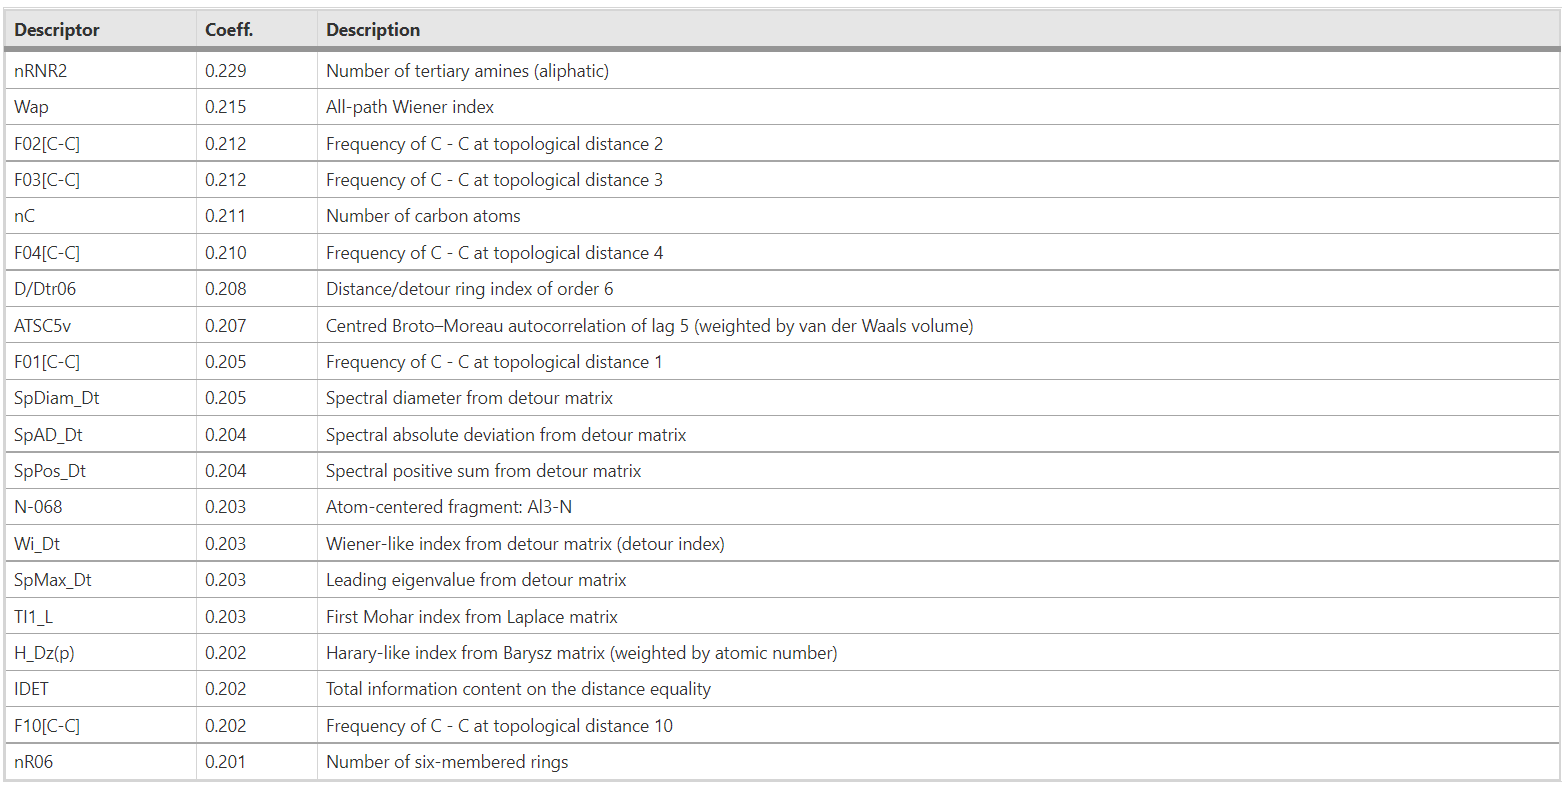


Due to excessive multicollinearity, an additional 33 features were removed from the final dataset.

In [ ]:
def calculate_VIFs(df):
  '''
  Calculates variance inflation factors for all features. Assumes constant is already added.
  '''
  return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).sort_values()

# Create copy of features with added constant for VIF calculation
X = add_constant(features_df)

# Calculate starting VIF for all features
vif_start = calculate_VIFs(X)

# Remove features with infinite VIF
for feature,vif in vif_start.items():
  if str(vif) == 'inf':
    del X[feature]

# Iteratively filter until 10 features remain 
while len(X.columns) > 10:

  # Get VIFs of current dataframe
  vifs = calculate_VIFs(X)

  # Remove feature with highest VIF
  del X[vifs.index[-1]]


The final features were listed with their respective correlation coefficients.

In [8]:
correlations_df.loc[correlations_df['Feature'].isin(list(X.columns))]

,Feature,Correlation to Y
9,CalcChi4v,0.095881
11,CalcFractionCSP3,0.059368
20,CalcNumAmideBonds,0.035420
24,CalcNumAtomStereoCenters,0.003422
26,CalcNumBridgeheadAtoms,0.009544
27,CalcNumHBA,0.027237
33,CalcNumLipinskiHBD,0.060668
35,CalcNumRotatableBonds,0.090021
39,CalcNumSpiroAtoms,0.004632
40,CalcNumUnspecifiedAtomStereoCenters,0.002101


We traded off high dimensional data with extreme multicollinearity for a smaller featureset with seemingly low predictive power. Though not optimal, we opted to use this data to train our models, as Pearson correlation only captures linear relationships. Nevertheless, evaluating models trained on this data later showed it to be insufficiently suitable for robust prediction.


## Data exploration



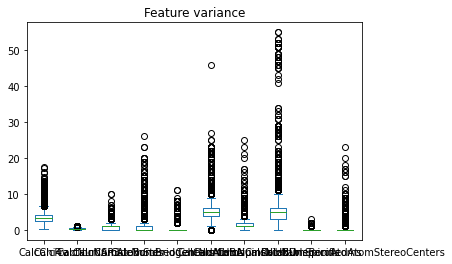

In [10]:
# Variance plot
X.plot.box(title = 'Feature variance',
             xlabel = 'no',
            legend = False)

Feature scaling was performed due to large differences in mean and variation between different features.

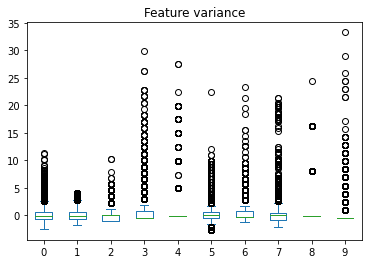

In [11]:
# Scale features
X = scale(X)
pd.DataFrame(X).plot.box(title = 'Feature variance',
             xlabel = 'no',
            legend = False)

Though outliers are still present, the interquartile ranges overlap much better after feature scaling.

Class ratios were calculated to assess data imbalance.

In [27]:
# Dependent variable
y = smiles_data['Y'].values

# Extract class ratio
ones, zeroes = list(y).count(1), list(y).count(0)
tot = ones + zeroes
ratio =  round(zeroes/ones)

# Output
print(f'Class distribution:\n0: {(zeroes/tot * 100):.3f} %\n1: {(ones/tot * 100):.3f} %\n')
print(f'Class ratio:\n{ratio}:1\n')

Class distribution:
0: 95.556 %
1: 4.444 %

Class ratio:
22:1



We noted a high degree of imbalance, which is not surpising given the nature of the data, as only a small minority of possible molecules will bind to a specific receptor. To approach this problem, we tried several techniques to minimize the impact of this class imbalance, which we will now describe briefly in the order they were tried.


1.   **No modifications**

Models were trained and evaluated using the unmodified dataset. As expected, performance was very bad across all models, even when applying stratification to ensure even class ratios between training and test sets.

2.   **Undersampling** 

Undersampling appeared to have very beneficial effects on the evaluation metrics of our own data. Sadly, these improved scores appeared to be mostly caused by overfitting, as the Kaggle test showed. Undersampling did greatly improve runtime due to smaller train/test sets. 

We continued to modify our approach to attempt minimizing data loss, as this method discarded roughly 90% of data (~ 180 000 molecules!). 

3. **Upweighting**

Upweighting the minority class to balance class ratios is somewhat similar to undersampling the majority class, while also using the entire dataset at the cost of greater computational time. This technique does rely heavily on the quality of the minority class, which did not seem problematic given its size (~10 000).

While the evaluations on Kaggle were roughly equal to those of undersampled models, they did not exhibit the same tendency to overestimate their own performance when evaluated on our own data. Nevertheless, performance remained very weak.


4. **Stratified k-fold cross validation with upweighting**

K-fold cross validation was combined with the aforementioned techniques in order to minimize model error. We partitioned the data into 4 folds, using stratification to ensure equal class ratios.

Visually, this approach works as follows. 

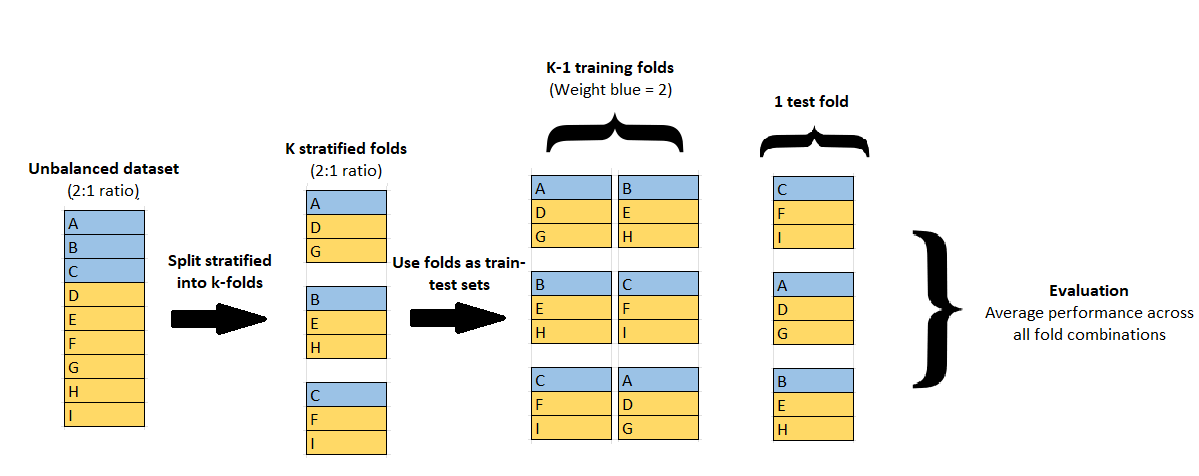

**Notes:**

1. Choice of K 

Increasing K comes at the cost of both fewer minority classes in each fold, and greater computational power. We decided to limit it to a value of 4, which also provides a reasonable 75/25 train-test split.

2. Test set class ratio

In the training set, the imbalances are corrected for (to a certain degree) by using weights.Though this is not the case in test sets, it need not be a problem; any realistic test set will be strongly imbalanced, as most molecules are not hERG binding. 

3. Weighting technicalities

The approach described in the image was applied whenever possible. If not, a standard undersampling approach was be used (e.g. K-nn).


## Evaluation metrics

Before discussing the models, we will briefly discuss the optimal way to evaluate their output.

### Main idea

To explain the rationale behind our evaluation strategy, we pose the following question.


> Pharmaceutical company X is screening compounds to use in drug development. Is it worse to classify a toxic molecule as non-toxic (FN), or a non-toxic molecule as toxic (FP)?


We refer back to our introduction on drug development, more specifically the financial side. If a candidate drug proves to be toxic, all prior investments will have been for nothing, as it will never reach the market. On the other hand, if a molecule is wrongfully discarded (predicted to be toxic without actually being toxic), the pharmaceutical company does not lose money. The odds of a molecule leading to a marketable drug are extremely low in the first place, and a near infinite amount of other candidates are available.

Thus, it is financially much more interesting to discard potentially non-toxic drugs early on (i.e. during computational screening) than it is to risk investing heavily in molecules that will prove toxic later. This essentially means attributing more value to recall than precision, though the tradeoff (f1-score) still remains important; models with high recall but very low precision are not informative.

### Accuracy 
Due to the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox), we did not use accuracy as a useful metric. We illustrate this with a spoof model.

In [47]:
# Predict with spoof model
def very_reliable_model(X_train, y_train, y_test_size):
  '''
  Performs (binary) classification by always predicting the most abundant class
  '''
  # Delete all features; our model doesn't need it
  del X_train

  # Extract majority class
  majority = np.bincount(y_train).argmax()

  # Always predict new observations to be the majority class
  predictions = y_test_size *[majority]
  
  return predictions

# Split the data (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# Predict toxicity on test set
preds = very_reliable_model(X_train, y_train, len(y_test))

# Evaluate
accuracy = metrics.accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy*100:.2f} %')

Accuracy: 95.56 %


Though completely non-informative, the model still returns a highly impressive 95% accuracy. We did not use accuracy to evaluate our models.

### F1 score
The f1 score is the harmonic mean between precision and recall. It takes both positives and negatives into account, making it a far more useful option for assessing model performance.

In [39]:
# Illustrate on spoof model
f1 = metrics.f1_score(y_test, preds)
print(f'F1 score: {f1}') 

F1 score: 0.0


### Matthews correlation coefficient

We also evaluated our models using the Matthews correlation coefficient (MCC). It produces a value in range [-1, 1],  only generating a high absolute score if both a majority of positive and negative data instances were predicted correctly. 

It is applicable to binary classification, even outperforming the f1-score as an evaluation metric in specific situations of unbalanced datasets (Chico & Jurman, 2020). 


In [31]:
# Illustrate on spoof model
mcc = metrics.matthews_corrcoef(y_test, preds)
print(f'MCC: {mcc}')

MCC: 0.0


### Summary evaluation function


In [33]:
def evaluate_model(y_true, y_pred):

  # F1
  f1 = metrics.f1_score(y_true, y_pred)
  
  # MCC
  mcc = metrics.matthews_corrcoef(y_true, y_pred)

  # Precision
  prec = metrics.precision_score(y_true, y_pred)

  # Recall
  rec =  metrics.recall_score(y_true, y_pred)

  # Confusion matrix
  mat = metrics.confusion_matrix(y_true, y_pred)

  # Return required information
  return {'f1': f1, 'MCC': mcc, 'recall': rec, 'precision': prec, 'conf_mat':mat}

## Machine learning models


### K-nearest neighbours

Class imbalance can strongly influence K-nn models, as classification happens 'by majority vote'. Using weights is less intuitive than with other approaches like logistic regression. Instead, we used a classic undersampling method with 4-fold crossvalidation.


In [34]:
### Undersampling

# Get indices of equal amount of zeroes and ones
i_1 = np.where(y == 1)[0]
i_0 = np.where(y == 0)[0][:len(i_1)]

# Combine
usmpl_i = np.concatenate((i_1, i_0))

# Get y and features at these indices
X_usmpl, y_usmpl = X[usmpl_i], y[usmpl_i] 

# Check balance
print(f'1: {np.count_nonzero(y_usmpl == 1)}\n0: {np.count_nonzero(y_usmpl == 1)}')

1: 9547
0: 9547


<ipython-input-35-69f1cedd53f9>:37: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_scores_df = fold_scores_df.groupby('k')['f1', "mcc", 'recall', "precision"].mean()


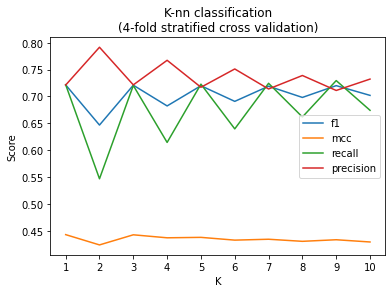

In [35]:
# Keep track of scores of each fold (k = 4)
fold_scores_df = pd.DataFrame(columns = ['k', 'fold', 'f1', 'mcc', 'recall', 'precision'])

# Initialize folds
folds = StratifiedKFold(n_splits=4, shuffle=True)

# Fold tracker
fold = 1
for train_index, test_index in folds.split(X_usmpl, y_usmpl):

  # Try for 1 - 10 neighbours
  for k in range(1,11):

      # Get X_train, X_test, y_train, y_test 
      X_train, X_test, y_train, y_test = X_usmpl[train_index], X_usmpl[test_index], y_usmpl[train_index], y_usmpl[test_index]

      # Initialize KNN
      knn = neighbors.KNeighborsClassifier(n_neighbors=k)

      # Fit to training data
      knn.fit(X_train, y_train)
      
      # Predict
      pred = knn.predict(X_test)

      # Evaluate
      result = evaluate_model(y_test, pred)

      # Add results to df
      add = [k, fold, result['f1'], result['MCC'], result['recall'], result['precision']]
      fold_scores_df.loc[len(fold_scores_df)] = add

  # Increment fold tracker
  fold += 1

# Get mean performance across folds
mean_scores_df = fold_scores_df.groupby('k')['f1', "mcc", 'recall', "precision"].mean()

# Plot
mean_scores_df.plot(title = 'K-nn classification\n(4-fold stratified cross validation)',
                    xlabel = 'K',
                    xticks = [i for i in range(1,11)],
                    ylabel = 'Score')

Performance seemed unreasonably good for such a simple model. The choice of k also seemed to have negligible effects, which is usually not the case in K-nearest neighbour classification.

Suspecting possible overfitting, we predicted the unknown test set and submitted the result on Kaggle. An f1 score of 0.15 confirmed our suspicions. This result was the main reasoning behind our further preference of upweighting the minority class, instead of undersampling the majority class. 




### Logistic regression

Rather than immediately balancing by class ratio, we opted to perform logistic regression using a range of different class weights.

In [38]:
# Define class weight list
weight_list = [{0:1, 1:r} for r in range(1,ratio+1)]

<ipython-input-40-2748a2f97063>:37: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_scores_logreg_df = logreg_scores_df.groupby('weight')['f1', "mcc", 'recall', "precision"].mean()


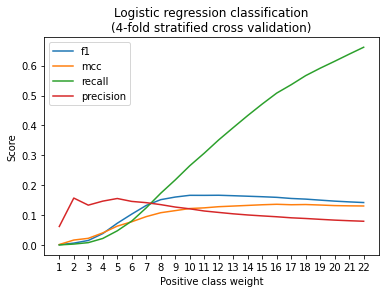

In [40]:
# Keep track of scores of each fold (k = 4)
logreg_scores_df = pd.DataFrame(columns = ['fold', 'weight', 'f1', 'mcc', 'recall', 'precision'])

# Initialize folds 
folds = StratifiedKFold(n_splits=4, shuffle=True)

# Fold tracker
fold = 1
for train_index, test_index in folds.split(X, y):

    # Try different weights
    for w in weight_list:

        # Get X_train, X_test, y_train, y_test 
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

        # Initialize KNN
        logreg = LogisticRegression(random_state=13, class_weight=w)

        # Fit to training data
        logreg.fit(X_train, y_train)
          
        # Predict
        pred = logreg.predict(X_test)

        # Evaluate
        result = evaluate_model(y_test, pred)

        # Add results to df
        add = [fold, w[1], result['f1'], result['MCC'], result['recall'], result['precision']]
        logreg_scores_df.loc[len(logreg_scores_df)] = add

    # Increment fold tracker
    fold += 1

# Get mean performance across folds
mean_scores_logreg_df = logreg_scores_df.groupby('weight')['f1', "mcc", 'recall', "precision"].mean()

# Plot
mean_scores_logreg_df.plot(title = 'Logistic regression classification\n(4-fold stratified cross validation)',
                    xlabel = 'Positive class weight',
                    xticks = [i for i in range(1,23)],
                    ylabel = 'Score')

Overall performance was again quite poor, though very similar to the Kaggle evaluations. Recall showed a strong positive correlation to weight, with precision understandably showing the inverse. 

We remarked that in the context of this research, recall is arguably more important than precision. Even so, at extremely low precision values, the amount of false positives becomes problematic; if nearly everything is predicted to be toxic even though only a small minority is, there is no point in performing the analysis.



### Decision trees

The same approach of upweighting and crossvalidation was applied to decision tree classification.

<ipython-input-41-def507e8f6f3>:37: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trees_mean_scores_df = trees_scores_df.groupby('weight')['f1', "mcc", 'recall', "precision"].mean()


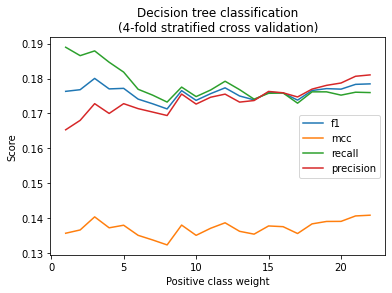

In [41]:
# Store in df
trees_scores_df = pd.DataFrame(columns=['weight', 'f1', 'mcc', 'recall', 'precision'])

# Initialize folds (technically already done, but we reshuffle)
folds = StratifiedKFold(n_splits=4, shuffle=True)

# Fold tracker
fold = 1
for train_index, test_index in folds.split(X, y):
    # Train & evaluate
    for w in weight_list:

      # Get X_train, X_test, y_train, y_test 
      X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

      # Initialize model
      trees_model = DecisionTreeClassifier(class_weight=w)

      # Fit
      trees_model.fit(X_train, y_train)

      # Predict
      pred = trees_model.predict(X_test)

      # Evaluate
      result = evaluate_model(y_test, pred)

      # Add results to df
      add = [w[1], result['f1'], result['MCC'], result['recall'], result['precision']]
      trees_scores_df.loc[len(trees_scores_df)] = add


    # Increment fold tracker
    fold += 1

# Get mean performance across folds
trees_mean_scores_df = trees_scores_df.groupby('weight')['f1', "mcc", 'recall', "precision"].mean()

# Plot
trees_mean_scores_df.plot(title = 'Decision tree classification\n(4-fold stratified cross validation)',
                    xlabel = 'Positive class weight',
                    xticks = [i for i in range(0,ratio, 5)],
                    ylabel = 'Score')


Similar to logistic regression, performance was weak but the evaluation was representative for effectiveness on unknown data. We also attempted random forest classification, which produced nearly identical results. Varying the number of trees [100, .. , 500] had no effect on performance.

### Support vector machines

Support vector classification is commonly used in drug discovery (Rodríguez-Pérez & Bajorath, 2022), but it was also the most computationally expensive approach we tried. To gauge runtime, we performed classification on the undersampled data.

In [42]:
# Keep track of scores of each fold (k = 5)
svc_scores_df = pd.DataFrame(columns = ['fold', 'f1', 'mcc', 'recall', 'precision'])

# Initialize folds (technically already done, but we reshuffle)
folds = StratifiedKFold(n_splits=4, shuffle=True)

# Fold tracker
fold = 1
for train_index, test_index in folds.split(X_usmpl, y_usmpl):

    # Get X_train, X_test, y_train, y_test 
    X_train, X_test, y_train, y_test = X_usmpl[train_index], X_usmpl[test_index], y_usmpl[train_index], y_usmpl[test_index]

    # Instantiate the Support Vector Classifier (SVC)
    svc = SVC(C=1.0, 
              random_state=1,
              kernel='linear')

    # Fit to training data
    svc.fit(X_train, y_train)
          
    # Predict
    pred = svc.predict(X_test)

    # Evaluate
    result = evaluate_model(y_test, pred)

    # Add results to df
    add = [fold, result['f1'], result['MCC'], result['recall'], result['precision']]
    svc_scores_df.loc[len(svc_scores_df)] = add

    # Increment fold tracker
    fold += 1

# Show results (No hyperparameters to plot)
svc_scores_df

,fold,f1,mcc,recall,precision
0,1.0,0.651211,0.300382,0.653121,0.649313
1,2.0,0.650342,0.294145,0.656473,0.644326
2,3.0,0.655970,0.308207,0.659405,0.652570
3,4.0,0.643036,0.282647,0.646270,0.639834


Similar to K-nearest neighbours and decision tree classification, predictions based on undersampled data produced overly positive and unreliable results (Kaggle f1 = 0.15).

Extreme runtimes prevented us from applying the same `SVC()` function to
the entire dataset using predefined weights. `LinearSVC` proved more efficient but still failed to converge, even after increasing the maximum iterations 200% from baseline. It also enforces the use of a linear kernel, which is not optimal on a high-dimensional dataset with poor linear correlations to its classes.

In [ ]:
# Redefine training & test data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Store in df
linearsvc_scores_df = pd.DataFrame(columns=['weight', 'f1', 'mcc', 'recall', 'precision'])

# Train & evaluate
for w in weight_list:

  # Initialize model
  clf = LinearSVC(random_state=0, class_weight = w)

  # Fit
  clf.fit(X_train, y_train)

  # Predict
  pred = clf.predict(X_test)

  # Evaluate
  result = evaluate_model(y_test, pred)

  # Add results to df
  add = [w[1], result['f1'], result['MCC'], result['recall'], result['precision']]
  linearsvc_scores_df.loc[len(linearsvc_scores_df)] = add

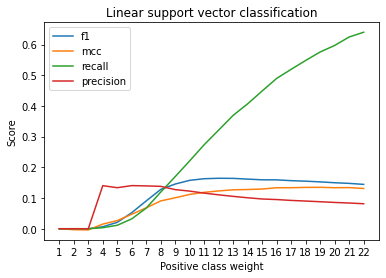

In [46]:
# Plot
linearsvc_scores_df.plot(x = 'weight', 
                         title = 'Linear support vector classification',
                         xlabel = 'Positive class weight',
                         xticks = [i for i in range(1,23)],
                         ylabel = 'Score')

## Discussion
We tried a number of different models to predict the hERG toxicity of different drugs based on their molecular structure. All of our methods produced subpar results, with the best only outperforming random predictions by a slim margin.  In this discussion, we aim to provide possible explanations for these results. In addition to this, we will also make a number of suggestions intended to guide future research, as to avoid running into the same problems.


### Feature engineering
Molecular feature extraction from SMILES is commonly done in cheminformatics, resulting in several open source libraries being available. From a practical standpoint, using other chemical notation systems likely confers little benefit compared to SMILES, the notable exception being a notation system for which more efficient feature extraction libraries exist.

We attempted to replicate the feature extraction approach used by researchers in cheminformatics; generating extremely high dimensional data. PaDEL-descriptor proved to be too computationally expensive for the given dataset, with calculated total runtime exceeding a month. We were forced to discard this approach, but want to stress that this was solely due to computational limitations; large (1000+) feature sets are highly valuable in complicated classification tasks, as evidenced by their ubiquitous use in recent publications.

As a more pragmatic approach, we opted for a limited number of features (~ 50). Due to high degree of multicollinearity, we progressively trimmed this down to 10 features whose variance inflation factor did not exceed 10. Pearson correlation between these features and the binary outcome was very weak, often not even exceeding 5%.  We remarked that this did not apply to non-linear types of correlation; however, most of our approaches were still reliant on linear relations between a feature and the dependent variable.
For any future researchers looking to tackle this problem, we strongly recommend either allocating a significant portion of effort in designing a memory efficient way to generate large feature sets, or to use more performant computers. 

### Modelling

We opted to try several models seen throughout the course, all of which produced very subpar results. Rather than analyzing these individually, we will discuss the overall trends and how they might be relevant to future research.

#### Undersampling vs. upweighting

Both methods are aimed at reducing the impact of the 20:1 class ratio on the predictive power of the model. Though their underlying ideas are similar, models trained on undersampled data (e.g. K-nn) strongly overrated their effectiveness on new data (f1 > 0.5), while their weighted counterparts provided more accurate (albeit bad) evaluations.

#### Correlations

Despite identifying a clear lack of linear separability between classes, we used machine learning approaches which are at least partially influenced by this. We did this to both test more models (K-nn) and out of necessity (linear kernel in SVC). It is difficult to say how these models would have performed given more informative features, but this does illustrate the need to tailor your machine learning algorithm to the data.



## References

* Paul, S., Mytelka, D., Dunwiddie, C. et al. How to improve R&D productivity: 
the pharmaceutical industry's grand challenge. Nat Rev Drug Discov 9, 203–214 (2010). https://doi.org/10.1038/nrd3078

* Macalino, S.J.Y., Gosu, V., Hong, S. et al. Role of computer-aided drug design in modern drug discovery. Arch. Pharm. Res. 38, 1686–1701 (2015). https://doi.org/10.1007/s12272-015-0640-5

* Amanda Garrido, Alban Lepailleur, Serge M. Mignani, Patrick Dallemagne, Christophe Rochais, hERG toxicity assessment: Useful guidelines for drug design, European Journal of Medicinal Chemistry, Volume 195, 2020, 112290,ISSN 0223-5234,https://doi.org/10.1016/j.ejmech.2020.112290.

* Yap, C.W. (2011), PaDEL-descriptor: An open source software to calculate molecular descriptors and fingerprints. J. Comput. Chem., 32: 1466-1474. https://doi.org/10.1002/jcc.21707

* Lee, HM., Yu, MS., Kazmi, S.R. et al. Computational determination of hERG-related cardiotoxicity of drug candidates. BMC Bioinformatics 20 (Suppl 10), 250 (2019). https://doi.org/10.1186/s12859-019-2814-5

* Chicco, D., Jurman, G. The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation. BMC Genomics 21, 6 (2020). https://doi.org/10.1186/s12864-019-6413-7

* Rodríguez-Pérez, R., Bajorath, J. Evolution of Support Vector Machine and Regression Modeling in Chemoinformatics and Drug Discovery. J Comput Aided Mol Des 36, 355–362 (2022). https://doi.org/10.1007/s10822-022-00442-9
